In [1]:
import os
os.chdir("../src")

### Experiment with training

In [2]:
from typing import List, Iterable, Union

import random
import matplotlib.pyplot as plt

from minitorch.autodiff import Scalar
from minitorch.optim import SGDOptimizer


random.seed(0)

In [3]:
# Generate some data
n_samples = 100

xs = list(range(n_samples))
errors = [random.gauss(0, 10) for _ in range(n_samples)]
m_true = Scalar(1.5)
c_true = Scalar(5)
y_true = [c_true + m_true * x + error for (x, error) in zip(xs, errors)]

len(xs), len(y_true)

(100, 100)

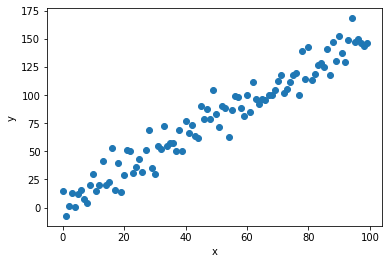

In [4]:
plt.scatter(xs, [y.data for y in y_true])
plt.xlabel("x")
plt.ylabel("y");

In [5]:
# Utils for training    
def mean_squared_error(y_hat: List[Scalar], y_true: List[Scalar]) -> Scalar:
    sum_of_squares = sum((y_t - y_h).square() for y_t, y_h in zip(y_true, y_hat))
    return sum_of_squares / len(y_hat)

def forward(xs: List[Union[float, Scalar]], m: Scalar, c: Scalar) -> List[Scalar]:
    return [(m*x + c) for x in xs]

def update(lr: float, parameters: Iterable[Scalar]) -> Iterable[Scalar]:
    for parameter in parameters:
        parameter.data = parameter.data - lr * parameter.derivative
    return parameters

def zero_grad(parameters: Iterable[Scalar]) -> Iterable[Scalar]:
    for parameter in parameters:
        parameter.zero_grad_()
    return parameters

In [6]:
# Scale data
xs_mean = sum(xs) / len(xs)
xs_std = (sum((x - xs_mean)**2 for x in xs) / (len(xs) - 1)) ** 1/2
xs_scaled = [(x - xs_mean) / xs_std for x in xs]

y_true_mean = sum(y_true) / len(y_true)
y_true_var = (sum((y - y_true_mean).square() for y in y_true) / (len(y_true) - 1))
y_true_std = y_true_var.data ** 1/2
y_true_scaled = [(y - y_true_mean) / y_true_std for y in y_true]

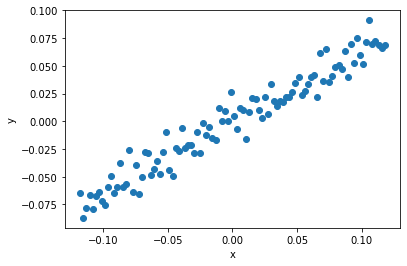

In [7]:
plt.scatter(xs_scaled, [y.data for y in y_true_scaled])
plt.xlabel("x")
plt.ylabel("y");

In [8]:
# Initialise parameters to estimate
m_hat = Scalar(random.gauss(0, 1))
c_hat = Scalar(0)

m_hat.requires_grad_(True)
c_hat.requires_grad_(False)

# Training loop
n_epochs = 100
learing_rate = 5.0

m_hats, c_hats, losses = [], [], []
for n_epoch in range(n_epochs):
    
    y_hat = forward(xs_scaled, m_hat, c_hat)
    loss = mean_squared_error(y_hat, y_true_scaled)
    loss.backward()
    update(lr=learing_rate, parameters=[m_hat])
    zero_grad(parameters=[m_hat])
    
    # Save values from epoch
    losses.append(loss.data)
    m_hats.append(m_hat.data)
    c_hats.append(c_hat.data)

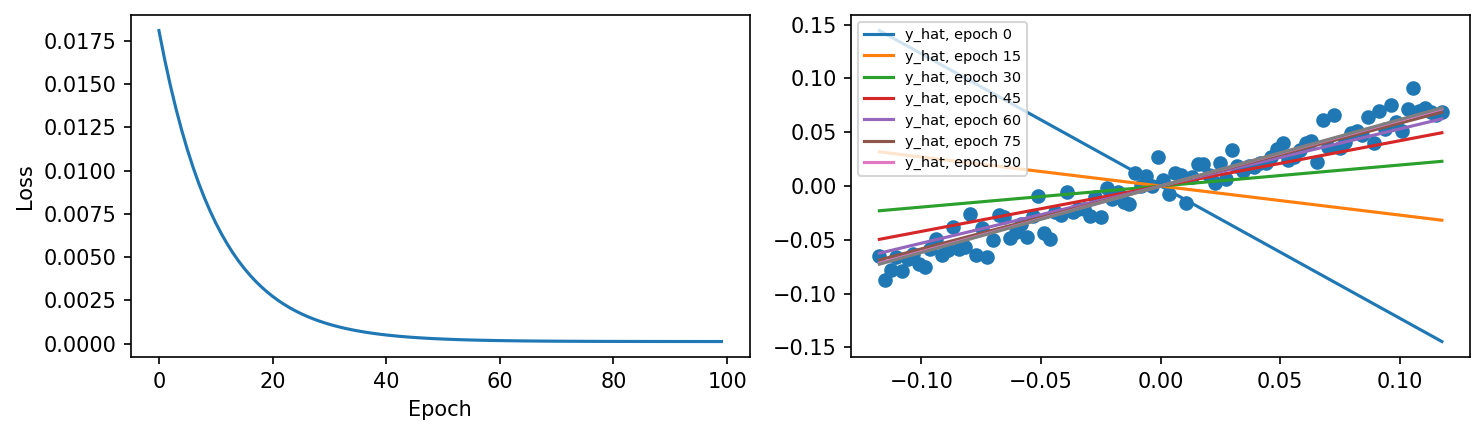

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=150)

# Loss vs. epoch
ax[0].plot(list(range(n_epochs)), losses)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")

# True vs. predicted w.r.t. epoch
for epoch in list(range(n_epochs))[::15]:
    ax[1].plot(
        xs_scaled, 
        [(m_hats[epoch] * x + c_hat).data for x in xs_scaled],
        label=f"y_hat, epoch {epoch}"
    )
ax[1].plot(xs_scaled, [y.data for y in y_hat])
ax[1].scatter(xs_scaled, [y.data for y in y_true_scaled])
ax[1].legend(fontsize="x-small")

fig.tight_layout()